In [56]:
! pip install textblob==0.9.0

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import bigrams
import os
from apyori import apriori
import networkx as nx 
from textblob import TextBlob
import itertools  
import collections
import emoji
import re
import spacy
from spacy.tokenizer import Tokenizer
from gensim.parsing.preprocessing import STOPWORDS as SW
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ritaguan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaguan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ritaguan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ritaguan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ritaguan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [119]:
df = pd.read_csv('/Users/ritaguan/Desktop/python_api.csv')
df.head()

,created_at,lang,author_id,text,id
0,2022-09-09T23:59:41.000Z,en,78429986,The pressure is mounting for asset owners to t...,1568388706762981378
1,2022-09-09T23:59:21.000Z,en,1515895379329708032,RT @dvdmckay: We’ve got a new paper out on cli...,1568388623288107008
2,2022-09-09T23:59:16.000Z,en,1547977583714660355,RT @DEATHBALL13: Let's not forget good old #Ch...,1568388601926524928
3,2022-09-09T23:58:51.000Z,en,1302354043793223680,RT @EnergyLiveNews: Prime Minister Liz Truss a...,1568388497152638978
4,2022-09-09T23:58:45.000Z,en,126075164,RT @EnergyHouseVA: ✅Europe’s Energy Crisis Wil...,1568388472695853056


In [120]:
df['text'].to_csv('arm.txt', header=None, index=None, sep='\t', mode='a')

In [121]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [122]:
def emoji_remove(text):
    emoji_list = [c for c in text if emoji.is_emoji(c)]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text


call_emoji_free = lambda x: emoji_remove(x)

df['text'] = df['text'].apply(call_emoji_free)

In [123]:
def url_remove(text):
    text = re.sub(r'http\S+', '', text)
    return text

#apply url moving function
df['text'] = df['text'].apply(url_remove)

In [124]:
nlp = spacy.load('en_core_web_sm')
tokenizer = Tokenizer(nlp.vocab)
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@', 'rt', 'RT','#']
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)
#ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


In [125]:
tokens = []

for doc in tokenizer.pipe(df['text'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['text_token'] = tokens

In [86]:
text_list = df['text_token'].tolist()

In [87]:
with open("positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]

with open("negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]

sentiment_words = positive_words + negative_words

In [88]:
sent_tokens=[]
negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
for idx, l in enumerate(text_list):
    for token in l:
        if token in sentiment_words:
            if idx>0:
                if text_list[idx-1] not in negations:
                    sent_tokens.append(token)
            else:
                sent_tokens.append(token)

In [89]:
def find_sent_words(target_list):
    return list(set(target_list).intersection(sent_tokens))

transactions = list(map(find_sent_words,text_list ))

In [82]:
transactions = [x for x in transactions if x != []]

In [90]:
pos_tokens=[]
negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
for idx, l in enumerate(text_list):
    for token in l:
        if token in positive_words:
            if idx>0:
                if text_list[idx-1] not in negations:
                    pos_tokens.append(token)
            else:
                pos_tokens.append(token)

In [96]:
def find_pos_words(target_list):
    return list(set(target_list).intersection(pos_tokens))

pos_transactions = list(map(find_pos_words,text_list))

pos_transactions = [x for x in pos_transactions if x != []]

In [100]:
neg_tokens=[]
negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
for idx, l in enumerate(text_list):
    for token in l:
        if token in negative_words:
            if idx>0:
                if text_list[idx-1] not in negations:
                    neg_tokens.append(token)
            else:
                neg_tokens.append(token)

In [101]:
def find_neg_words(target_list):
    return list(set(target_list).intersection(neg_tokens))

neg_transactions = list(map(find_neg_words,text_list))

neg_transactions = [x for x in neg_transactions if x != []]

In [68]:
def reformat_results(results):

    keep = []
    for i in range(0, len(results)):
        for j in range(0, len(list(results[i]))):
            if(j>1):
                for k in range(0, len(list(results[i][j]))):
                    if(len(results[i][j][k][0]) != 0):
                        rhs = list(results[i][j][k][0])
                        lhs = list(results[i][j][k][1])
                        conf = float(results[i][j][k][2])
                        lift = float(results[i][j][k][3])
                        keep.append([rhs, lhs, supp,conf, supp*conf, lift])
            if(j == 1):
                supp = results[i][j]

    return pd.DataFrame(keep, columns=["rhs","lhs","supp","conf","supp * conf", "lift"])


In [69]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

In [70]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Dracula')
    plt.show()

# raise

                                            rhs           lhs      supp  conf  \
0                                   [advocates]     [leading]  0.018182   1.0   
1                                     [leading]   [advocates]  0.018182   1.0   
2                                   [advocates]    [powerful]  0.018182   1.0   
3                                    [powerful]   [advocates]  0.018182   0.5   
4                                   [advocates]  [protection]  0.018182   1.0   
..                                          ...           ...       ...   ...   
201  [powerful, advocates, protection, leading]       [thank]  0.018182   1.0   
202       [powerful, advocates, thank, leading]  [protection]  0.018182   1.0   
203     [advocates, thank, protection, leading]    [powerful]  0.018182   1.0   
204    [powerful, advocates, thank, protection]     [leading]  0.018182   1.0   
205      [powerful, protection, thank, leading]   [advocates]  0.018182   1.0   

     supp * conf  lift  
0 

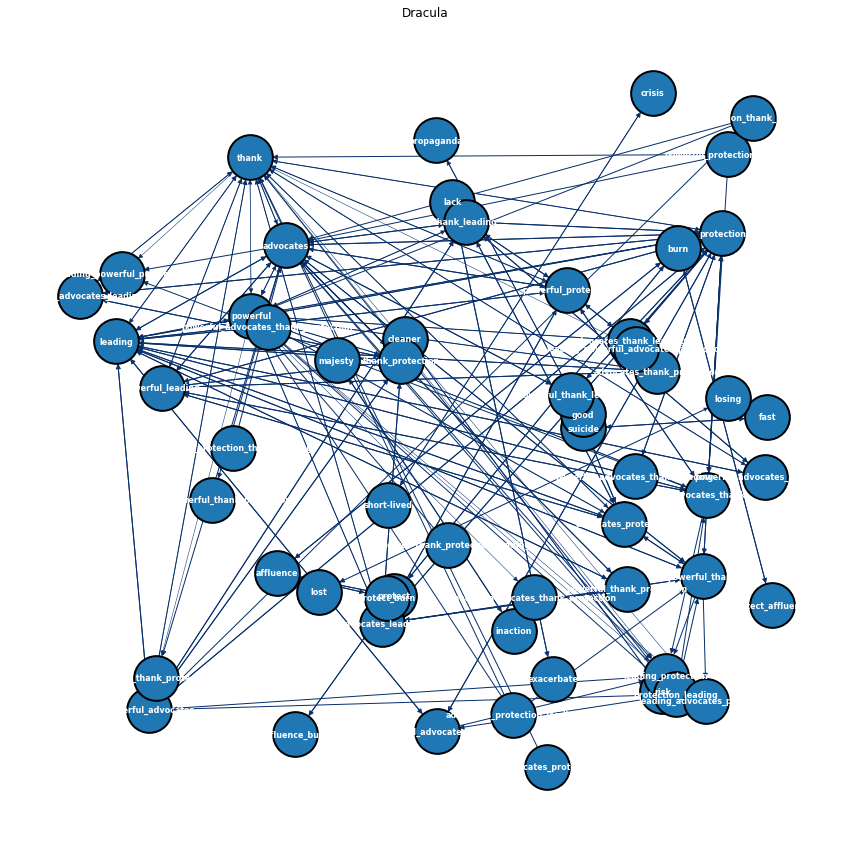

In [71]:
results = list(apriori(transactions, min_support = 0.003, min_confidence = 0.02, min_length = 1, max_length=5))
pd_results = reformat_results(results)
G = convert_to_network(pd_results)
plot_network(G)

In [126]:
pd_results

,rhs,lhs,supp,conf,supp * conf,lift
0,[advocates],[leading],0.018182,1.0,0.018182,55.0
1,[leading],[advocates],0.018182,1.0,0.018182,55.0
2,[advocates],[powerful],0.018182,1.0,0.018182,27.5
3,[powerful],[advocates],0.018182,0.5,0.009091,27.5
4,[advocates],[protection],0.018182,1.0,0.018182,55.0
...,...,...,...,...,...,...
201,"[powerful, advocates, protection, leading]",[thank],0.018182,1.0,0.018182,27.5
202,"[powerful, advocates, thank, leading]",[protection],0.018182,1.0,0.018182,55.0
203,"[advocates, thank, protection, leading]",[powerful],0.018182,1.0,0.018182,27.5
204,"[powerful, advocates, thank, protection]",[leading],0.018182,1.0,0.018182,55.0


                                            rhs           lhs      supp  conf  \
0                                   [advocates]     [leading]  0.058824   1.0   
1                                     [leading]   [advocates]  0.058824   1.0   
2                                   [advocates]    [powerful]  0.058824   1.0   
3                                    [powerful]   [advocates]  0.058824   0.5   
4                                   [advocates]  [protection]  0.058824   1.0   
..                                          ...           ...       ...   ...   
177  [powerful, advocates, protection, leading]       [thank]  0.058824   1.0   
178       [powerful, advocates, thank, leading]  [protection]  0.058824   1.0   
179     [advocates, thank, protection, leading]    [powerful]  0.058824   1.0   
180    [powerful, advocates, thank, protection]     [leading]  0.058824   1.0   
181      [powerful, protection, thank, leading]   [advocates]  0.058824   1.0   

     supp * conf  lift  
0 

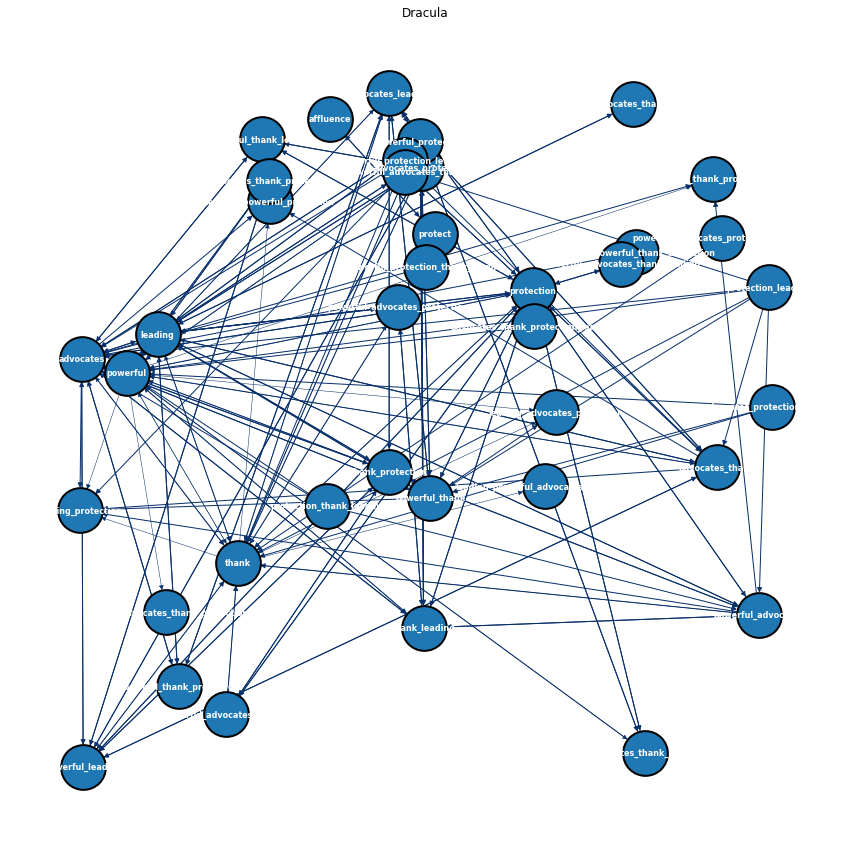

In [103]:
pos_results = list(apriori(pos_transactions, min_support = 0.003, min_confidence = 0.02, min_length = 1, max_length=5))
pd_pos_results = reformat_results(pos_results)
G_pos = convert_to_network(pd_pos_results)
plot_network(G_pos)

In [127]:
pd_pos_results

,rhs,lhs,supp,conf,supp * conf,lift
0,[advocates],[leading],0.058824,1.0,0.058824,17.0
1,[leading],[advocates],0.058824,1.0,0.058824,17.0
2,[advocates],[powerful],0.058824,1.0,0.058824,8.5
3,[powerful],[advocates],0.058824,0.5,0.029412,8.5
4,[advocates],[protection],0.058824,1.0,0.058824,17.0
...,...,...,...,...,...,...
177,"[powerful, advocates, protection, leading]",[thank],0.058824,1.0,0.058824,8.5
178,"[powerful, advocates, thank, leading]",[protection],0.058824,1.0,0.058824,17.0
179,"[advocates, thank, protection, leading]",[powerful],0.058824,1.0,0.058824,8.5
180,"[powerful, advocates, thank, protection]",[leading],0.058824,1.0,0.058824,17.0


             rhs            lhs      supp      conf  supp * conf       lift
0       [crisis]  [short-lived]  0.042553  0.666667     0.028369  15.666667
1  [short-lived]       [crisis]  0.042553  1.000000     0.042553  15.666667
2   [exacerbate]         [lack]  0.021277  1.000000     0.021277  47.000000
3         [lack]   [exacerbate]  0.021277  1.000000     0.021277  47.000000
4       [losing]         [lost]  0.021277  1.000000     0.021277   7.833333
5         [lost]       [losing]  0.021277  0.166667     0.003546   7.833333


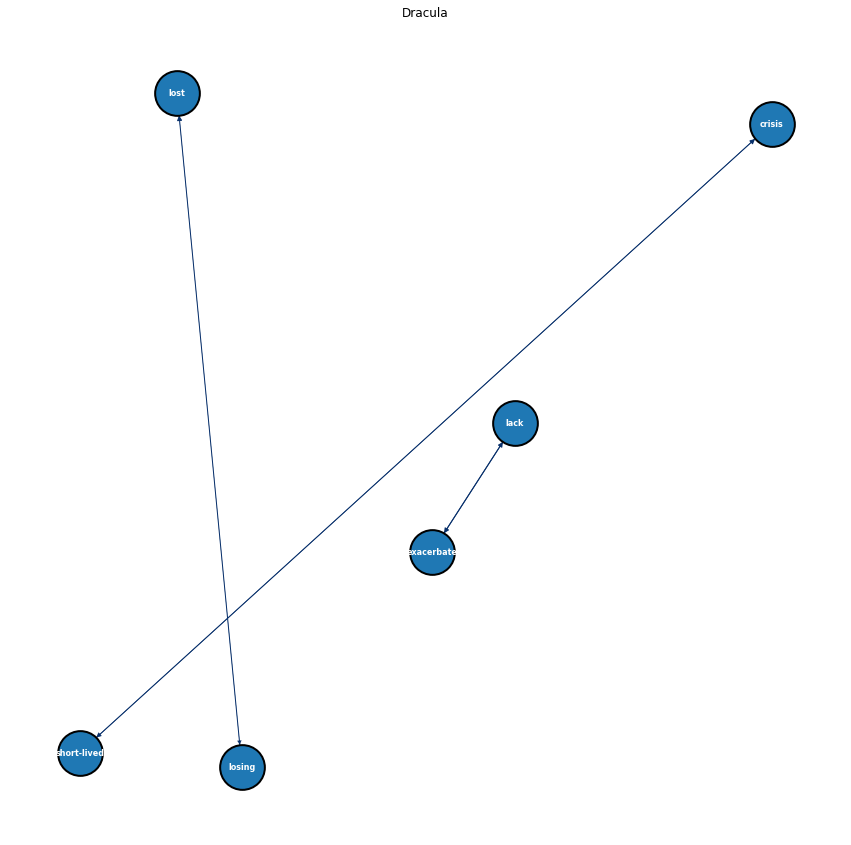

In [105]:
neg_results = list(apriori(neg_transactions, min_support = 0.003, min_confidence = 0.02, min_length = 1, max_length=5))
pd_neg_results = reformat_results(neg_results)
G_neg = convert_to_network(pd_neg_results)
plot_network(G_neg)

In [128]:
pd_neg_results

,rhs,lhs,supp,conf,supp * conf,lift
0,[crisis],[short-lived],0.042553,0.666667,0.028369,15.666667
1,[short-lived],[crisis],0.042553,1.000000,0.042553,15.666667
2,[exacerbate],[lack],0.021277,1.000000,0.021277,47.000000
3,[lack],[exacerbate],0.021277,1.000000,0.021277,47.000000
4,[losing],[lost],0.021277,1.000000,0.021277,7.833333
5,[lost],[losing],0.021277,0.166667,0.003546,7.833333
